In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

from collections import OrderedDict

# Set a random seed to ensure reproducibility across runs
RNG_SEED = 42
np.random.seed(RNG_SEED)

In [27]:
PATH = os.getcwd()
train_path = os.path.join(PATH, 'zt_data_cleaned2.csv')

df_train = pd.read_csv(train_path)


print(f'df_train DataFrame shape: {df_train.shape}')


df_train DataFrame shape: (263, 5)


In [28]:
# Sub-sample the data. Set the random_state to make the sampling reproducible every time.
df_train_sampled = df_train.sample(n=100, random_state=RNG_SEED)


print(f'df_train_sampled DataFrame shape: {df_train_sampled.shape}')


df_train_sampled DataFrame shape: (100, 5)


In [29]:
# Import the package and the generate_features function
from cbfv.composition import generate_features

In [30]:
print('DataFrame column names before renaming:')
print(df_train.columns)


rename_dict = {'zt': 'target', 'Material': 'formula'}
df_train = df_train.rename(columns=rename_dict)


df_train_sampled = df_train_sampled.rename(columns=rename_dict)


print('\nDataFrame column names after renaming:')
print(df_train.columns)

df_train_sampled.head()

DataFrame column names before renaming:
Index(['formula', 'zt', 'k', 'c', 'S'], dtype='object')

DataFrame column names after renaming:
Index(['formula', 'target', 'k', 'c', 'S'], dtype='object')


,formula,target,k,c,S
115,Bi1Cu1Se0.96Te0.04O1,0.320000,0.544600,18.066000,369.042000
120,Bi1Cu1Se0.80Te0.20O1,0.260000,0.452100,14.868000,337.597000
259,Bi0.98Pb0.02Cu0.98Ag0.02Se1O1,0.613143,0.723237,88.566463,268.632371
226,Bi0.92Yb0.08Cu1Se1O1,0.200000,0.423200,10.168000,350.129000
66,Bi0.90Na0.10Cu1Se1O1,0.350000,0.695400,63.488000,244.598000


In [31]:
x_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df_train, elem_prop='Magpie', drop_duplicates=False, extend_features=True, sum_feat=True)


Assigning Features...: 100%|██████████| 263/263 [00:00<00:00, 9790.73it/s]

	Featurizing Compositions...
	Creating Pandas Objects...


In [32]:
y_train.head(10
                     )

0    0.92
1    0.71
2    0.67
3    0.66
4    0.64
5    0.38
6    0.51
7    0.49
8    0.54
9    0.25
Name: target, dtype: float64

In [34]:
PATH = os.getcwd()

train_path = os.path.join(PATH, 'cbvf_of_zt2.csv')


x_train_unscaled.to_csv(train_path, index=False)


In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

In [54]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train_unscaled)
x_val = scaler.transform(x_val_unscaled)
x_test = scaler.transform(x_test_unscaled)

In [55]:
y_test.head()


0    0.430000
1    0.360000
2    0.370000
3    0.235338
4    0.470000
Name: target, dtype: float64

In [56]:
x_train = normalize(x_train)
x_val = normalize(x_val)
x_test = normalize(x_test)

In [57]:
# we import the algorithm here
from sklearn.ensemble import RandomForestRegressor

# we will set rf to be a specific instance of the random forest algorithm,
# matching the parameters that we define here
rf = RandomForestRegressor(n_estimators=150, max_depth=40, min_samples_leaf=1)

# we will create a model based on our data.
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

score: -0.0010253385884078092


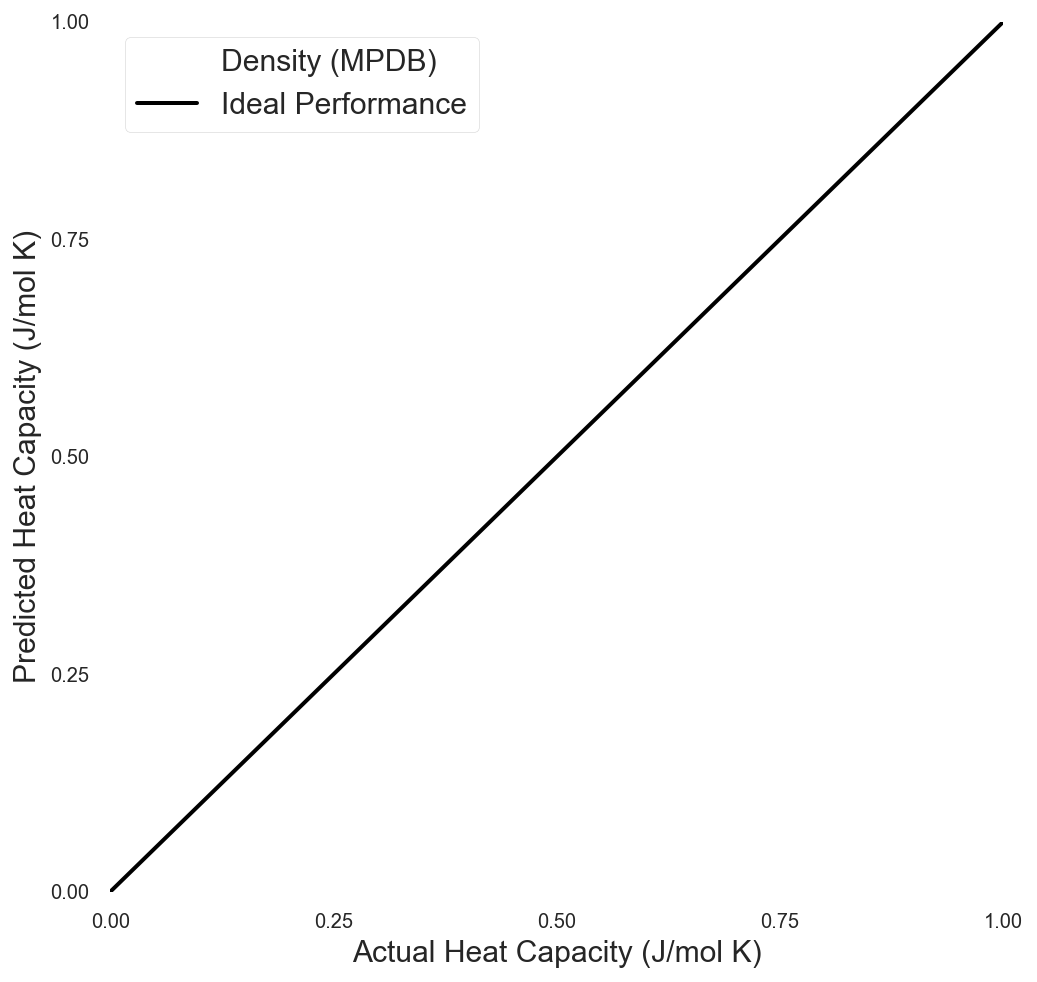

In [58]:
y_predict = rf.predict(x_test)

print('score:', rf.score(x_test, y_test))

plt.figure(1, figsize=(8, 8))
plt.plot(y_test, y_predict, 'ro', markersize=30, mfc='none')
plt.plot([0,1000],[0,1000], 'k', linewidth=2)
plt.xlabel('Actual Heat Capacity (J/mol K)', fontsize=15)
plt.ylabel('Predicted Heat Capacity (J/mol K)', fontsize=15)
plt.xlim((0, max(y_test)))
plt.ylim((0, max(y_test)))
ticks = np.linspace(0, 1, 5)
plt.xticks(ticks)
plt.yticks(ticks)
plt.legend(['Density (MPDB)','Ideal Performance'], loc='best', fontsize=15)

In [59]:
from time import time

from sklearn.dummy import DummyRegressor

from sklearn.linear_model import Ridge

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [60]:
def instantiate_model(model_name):
    model = model_name()
    return model

def fit_model(model, x_train, y_train):
    ti = time()
    model = instantiate_model(model)
    model.fit(x_train, y_train)
    fit_time = time() - ti
    return model, fit_time

def evaluate_model(model, x, y_act):
    y_pred = model.predict(x)
    r2 = r2_score(y_act, y_pred)
    mae = mean_absolute_error(y_act, y_pred)
    rmse_val = mean_squared_error(y_act, y_pred, squared=False)
    return r2, mae, rmse_val

def fit_evaluate_model(model, model_name, x_train, y_train, x_val, y_act_val):
    model, fit_time = fit_model(model, x_train, y_train)
    r2_train, mae_train, rmse_train = evaluate_model(model, x_train, y_train)
    r2_val, mae_val, rmse_val = evaluate_model(model, x_val, y_act_val)
    result_dict = {
        'model_name': model_name,
        'model_name_pretty': type(model).__name__,
        'model_params': model.get_params(),
        'fit_time': fit_time,
        'r2_train': r2_train,
        'mae_train': mae_train,
        'rmse_train': rmse_train,
        'r2_val': r2_val,
        'mae_val': mae_val,
        'rmse_val': rmse_val}
    return model, result_dict

def append_result_df(df, result_dict):
    df_result_appended = df.append(result_dict, ignore_index=True)
    return df_result_appended

def append_model_dict(dic, model_name, model):
    dic[model_name] = model
    return dic

In [61]:
df_classics = pd.DataFrame(columns=['model_name',
                                    'model_name_pretty',
                                    'model_params',
                                    'fit_time',
                                    'r2_train',
                                    'mae_train',
                                    'rmse_train',
                                    'r2_val',
                                    'mae_val',
                                    'rmse_val'])
df_classics

,model_name,model_name_pretty,model_params,fit_time,r2_train,mae_train,rmse_train,r2_val,mae_val,rmse_val


In [62]:
# Build a dictionary of model names
classic_model_names = OrderedDict({
    'dumr': DummyRegressor,
    'rr': Ridge,
    'abr': AdaBoostRegressor,
    'gbr': GradientBoostingRegressor,
    'rfr': RandomForestRegressor,
    'etr': ExtraTreesRegressor,
    'svr': SVR,
    'lsvr': LinearSVR,
    'knr': KNeighborsRegressor,
})

In [63]:
# Instantiate a dictionary to store the model objects
classic_models = OrderedDict()

# Keep track of elapsed time
ti = time()

# Loop through each model type, fit and predict, and evaluate and store results
for model_name, model in classic_model_names.items():
    print(f'Now fitting and evaluating model {model_name}: {model.__name__}')
    model, result_dict = fit_evaluate_model(model, model_name, x_train, y_train, x_val, y_val)
    df_classics = append_result_df(df_classics, result_dict)
    classic_models = append_model_dict(classic_models, model_name, model)

dt = time() - ti
print(f'Finished fitting {len(classic_models)} models, total time: {dt:0.2f} s')

Now fitting and evaluating model dumr: DummyRegressor
Now fitting and evaluating model rr: Ridge
Now fitting and evaluating model abr: AdaBoostRegressor
Now fitting and evaluating model gbr: GradientBoostingRegressor
Now fitting and evaluating model rfr: RandomForestRegressor
Now fitting and evaluating model etr: ExtraTreesRegressor
Now fitting and evaluating model svr: SVR
Now fitting and evaluating model lsvr: LinearSVR
Now fitting and evaluating model knr: KNeighborsRegressor
Finished fitting 9 models, total time: 1.22 s


/Users/TaoNP/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [64]:
# Sort in order of increasing validation r2 score
df_classics = df_classics.sort_values('r2_val', ignore_index=True)
df_classics

,model_name,model_name_pretty,model_params,fit_time,r2_train,mae_train,rmse_train,r2_val,mae_val,rmse_val
0,dumr,DummyRegressor,"{'constant': None, 'quantile': None, 'strategy...",0.000308,0.000000,1.952259e-01,0.241570,-0.017764,0.209462,0.248762
1,lsvr,LinearSVR,"{'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_...",0.012131,0.652333,8.222633e-02,0.142438,0.090474,0.179100,0.235163
2,knr,KNeighborsRegressor,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.000803,0.533477,1.269170e-01,0.164998,0.366749,0.150910,0.196222
3,rr,Ridge,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.005216,0.655841,1.113162e-01,0.141717,0.400897,0.162452,0.190858
4,svr,SVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",0.004750,0.810176,9.173225e-02,0.105249,0.522583,0.145487,0.170376
5,gbr,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",0.192454,0.975257,3.137020e-02,0.037999,0.546297,0.129421,0.166091
6,abr,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",0.139090,0.867596,7.414824e-02,0.087901,0.567330,0.129493,0.162196
7,rfr,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",0.395441,0.929360,4.710660e-02,0.064205,0.626717,0.116158,0.150654
8,etr,ExtraTreesRegressor,"{'bootstrap': False, 'ccp_alpha': 0.0, 'criter...",0.339096,1.000000,2.374450e-07,0.000001,0.685907,0.106824,0.138194


In [65]:
classic_models

OrderedDict([('dumr',
              DummyRegressor(constant=None, quantile=None, strategy='mean')),
             ('rr',
              Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
                    normalize=False, random_state=None, solver='auto', tol=0.001)),
             ('abr',
              AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                                n_estimators=50, random_state=None)),
             ('gbr',
              GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                                        init=None, learning_rate=0.1, loss='ls', max_depth=3,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0, min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0, n_estimat

In [66]:
def plot_pred_act(act, pred, model, reg_line=True, label=''):
    xy_max = np.max([np.max(act), np.max(pred)])

    plot = plt.figure(figsize=(8,8))
    plt.plot(act, pred, 'o', ms=9, mec='k', mfc='red', alpha=0.4)
    plt.plot([0, xy_max], [0, xy_max], 'k--', label='ideal')
    if reg_line:
        polyfit = np.polyfit(act, pred, deg=1)
        reg_ys = np.poly1d(polyfit)(np.unique(act))
        plt.plot(np.unique(act), reg_ys, alpha=0.8, label='linear fit')
    plt.axis('scaled')
    plt.xlabel(f'Actual {label}')
    plt.ylabel(f'Predicted {label}')
    plt.title(f'{type(model).__name__}, r2: {r2_score(act, pred):0.4f}')
    plt.legend(loc='upper left')
    
    return plot

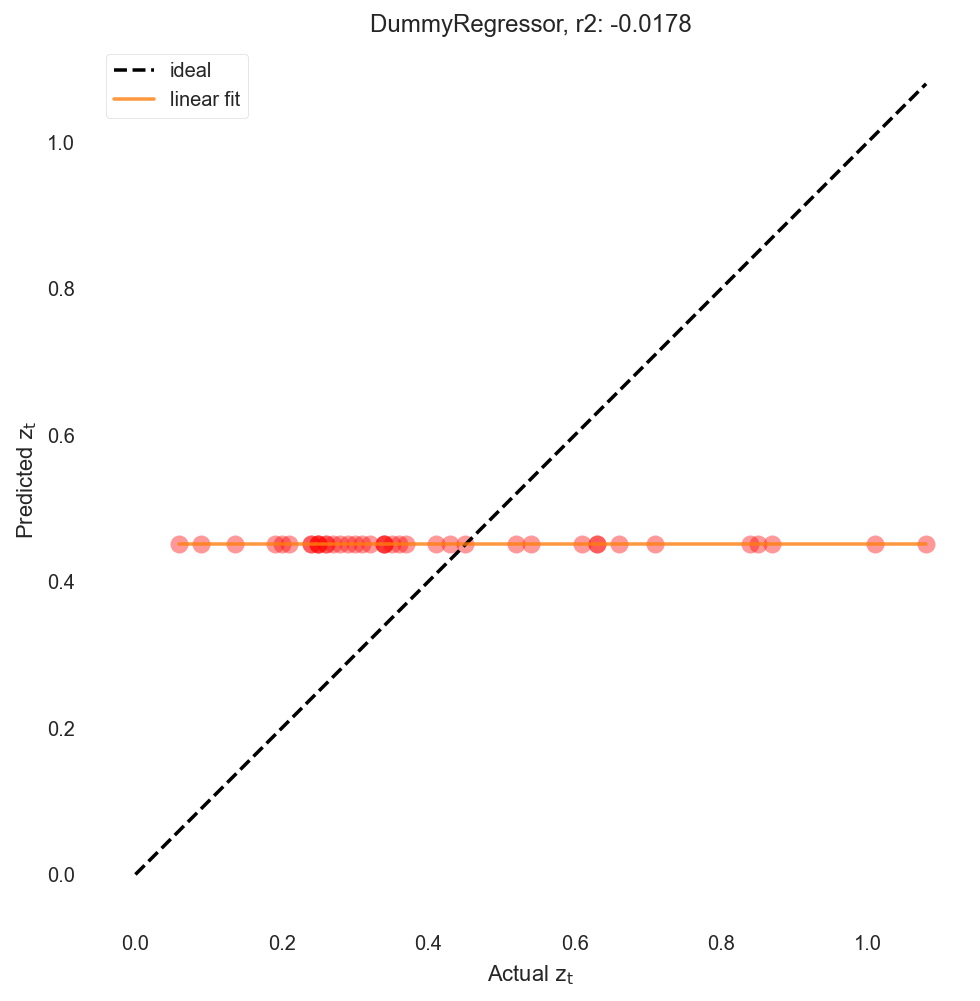

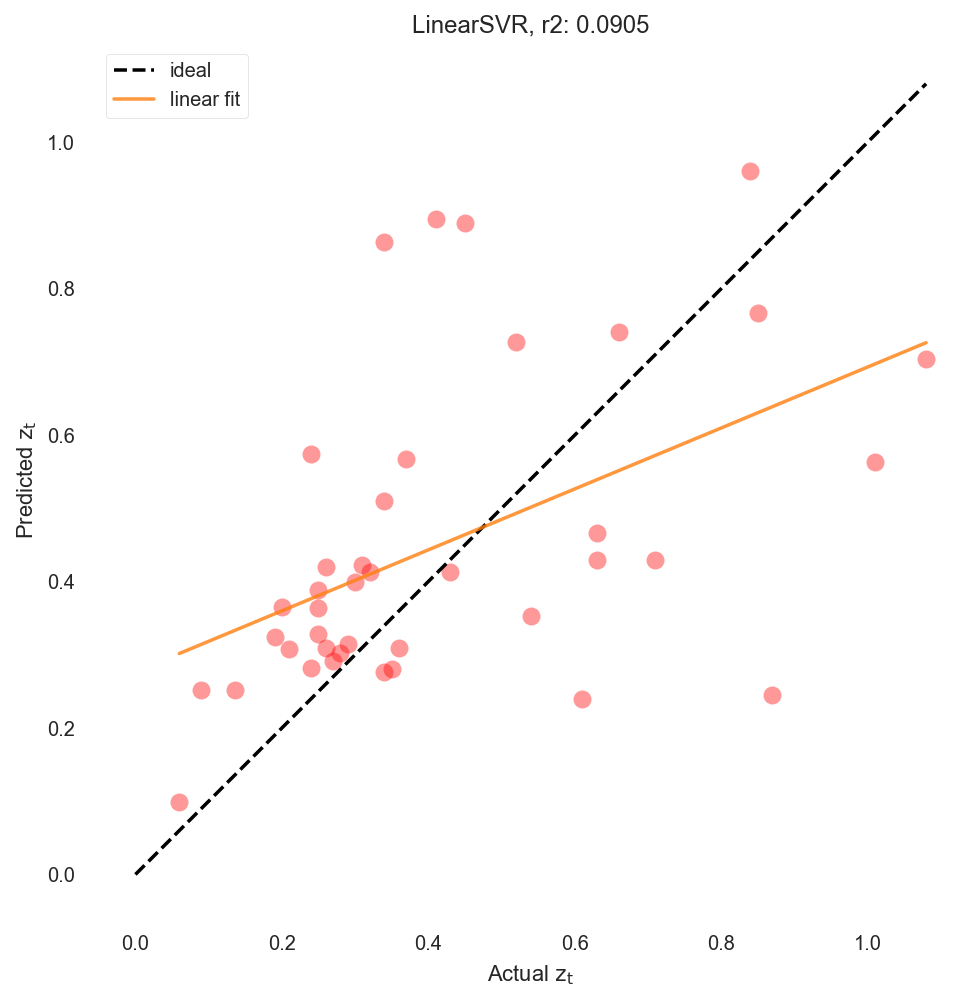

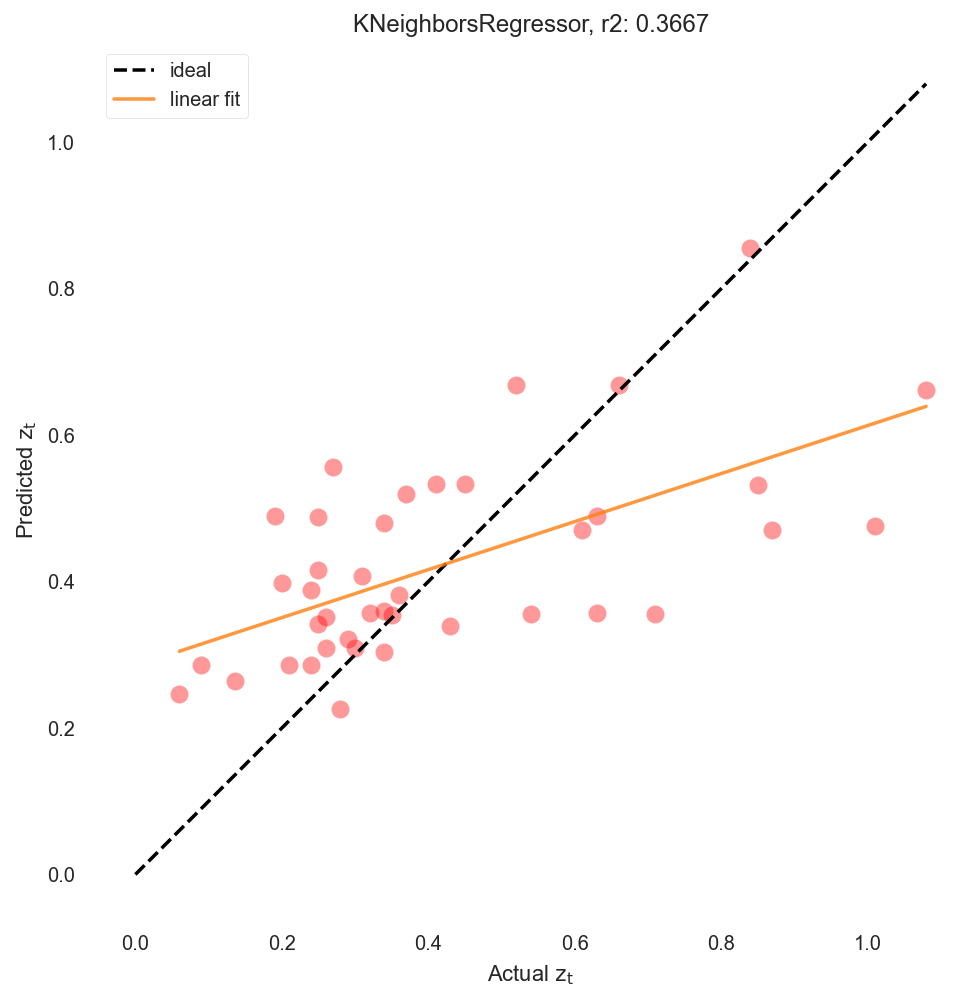

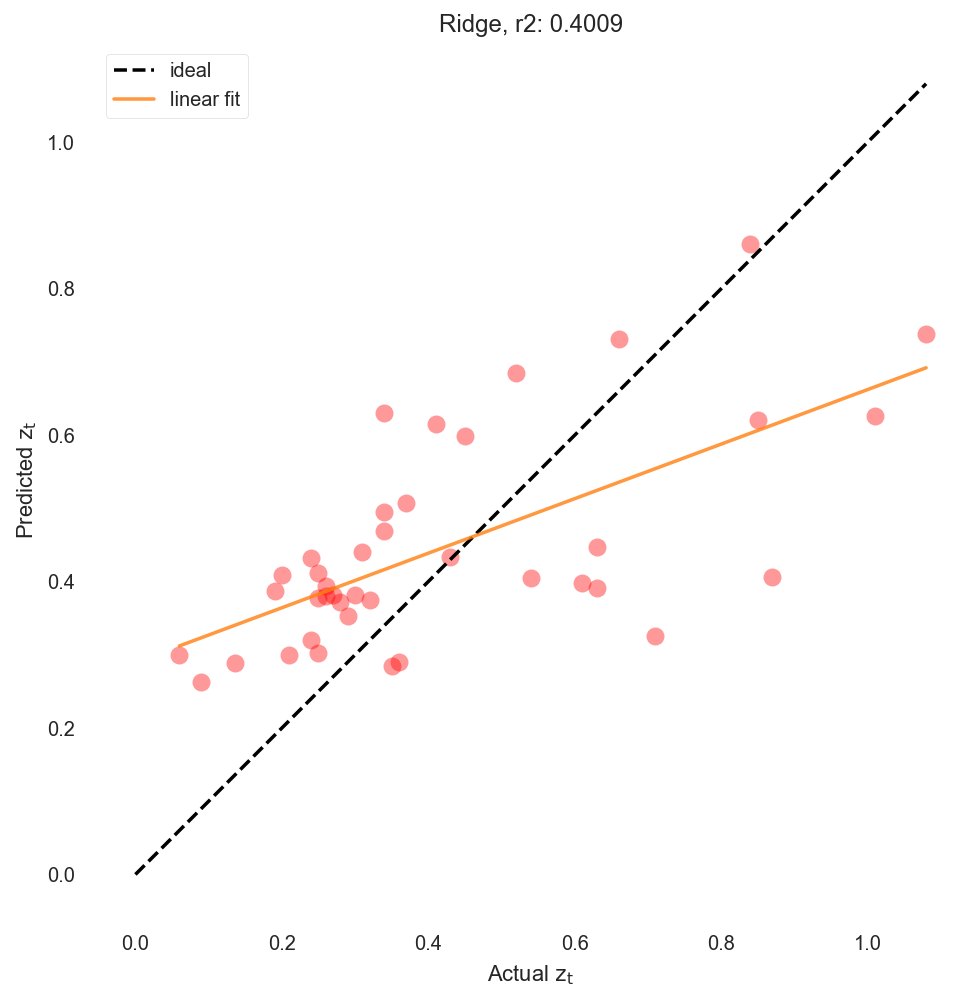

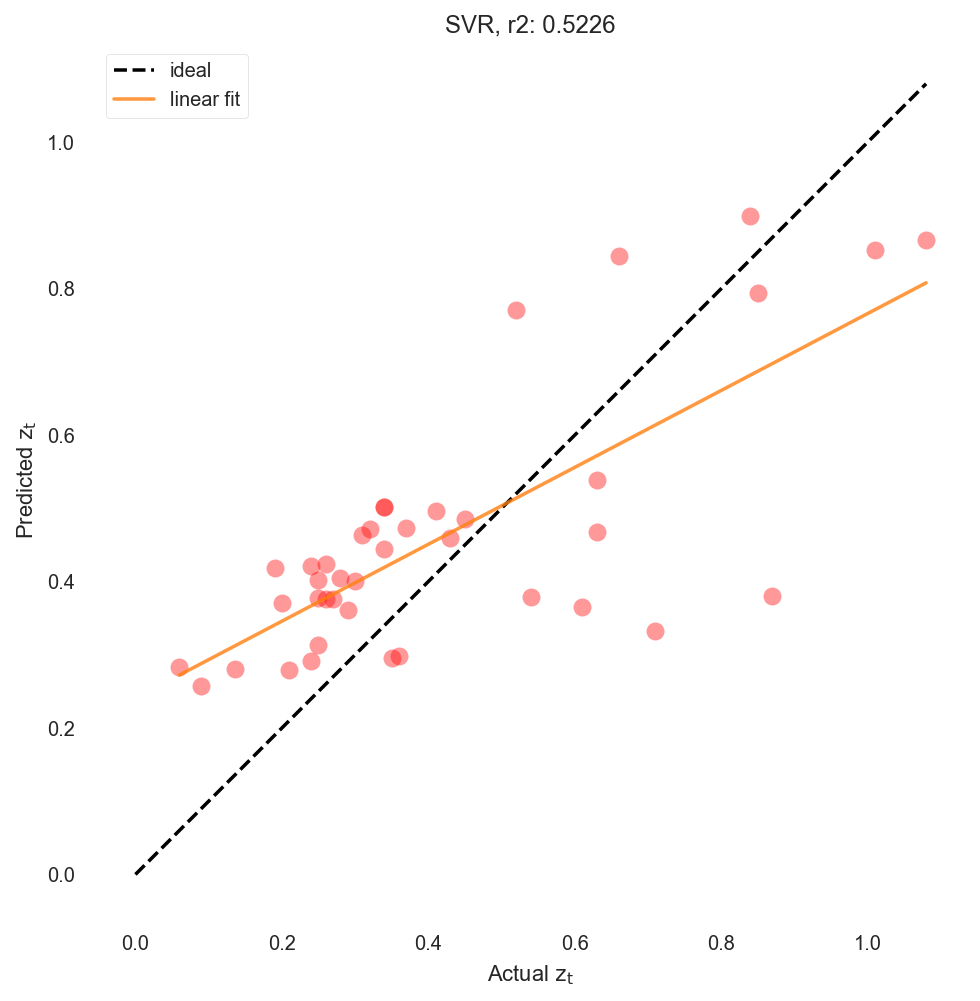

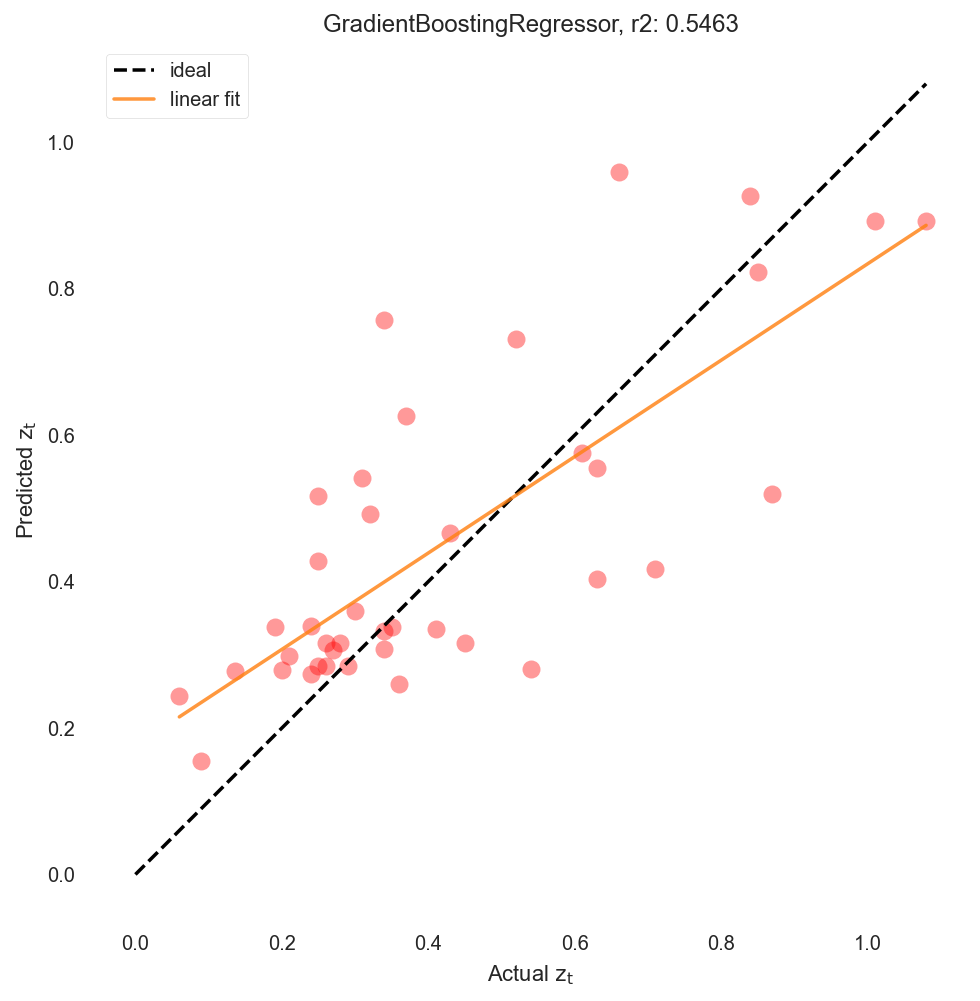

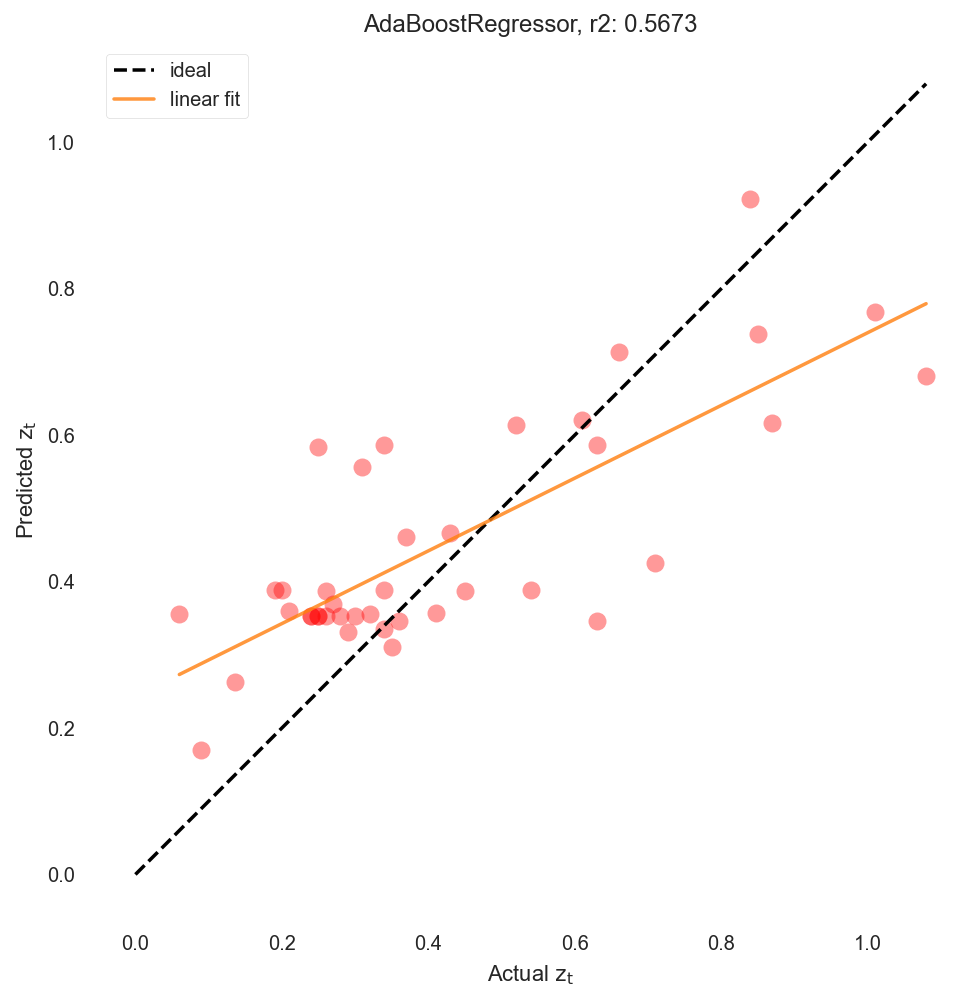

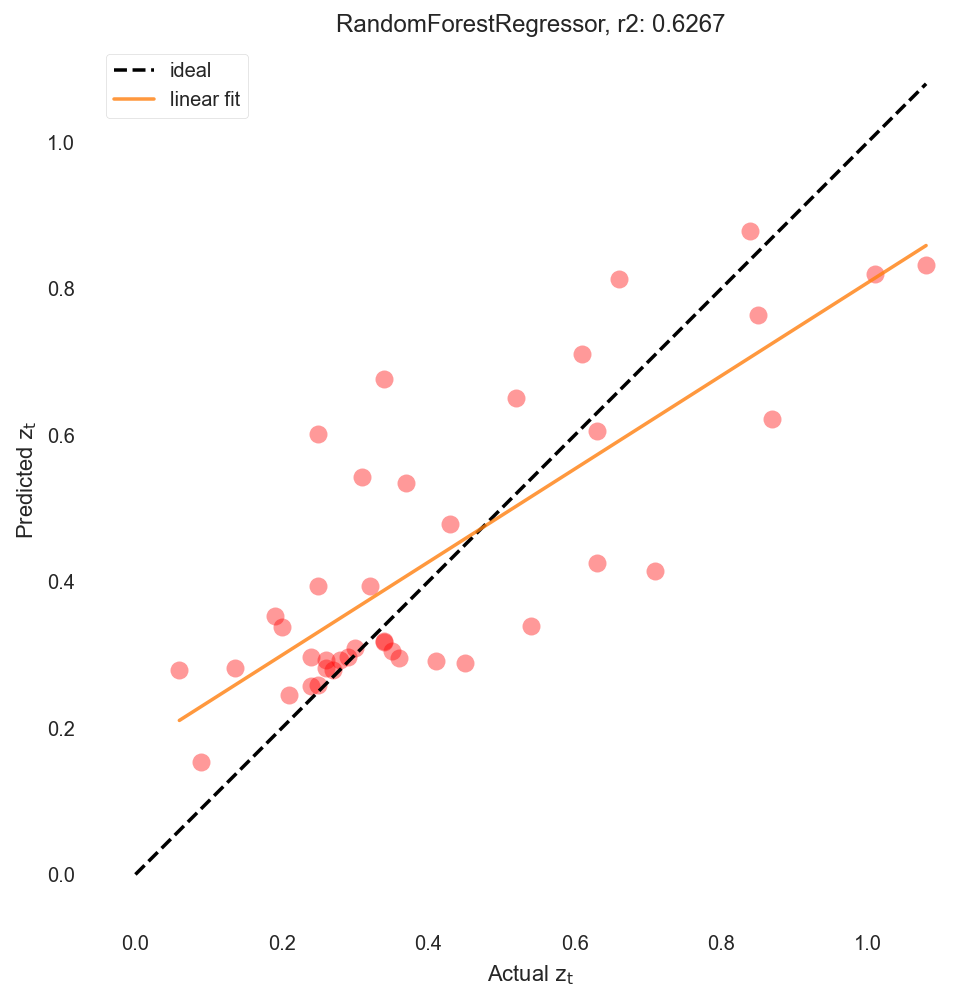

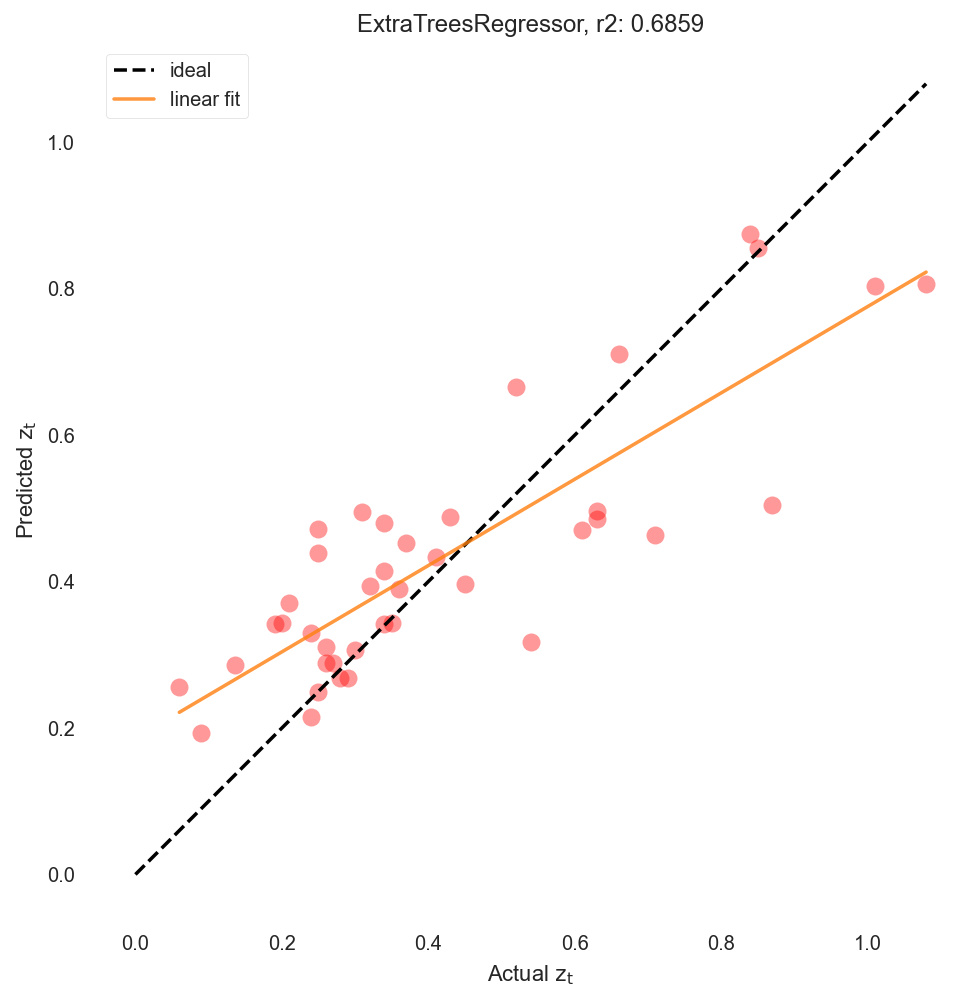

In [67]:
for row in range(df_classics.shape[0]):
    model_name = df_classics.iloc[row]['model_name']

    model = classic_models[model_name]
    y_act_val = y_val
    y_pred_val = model.predict(x_val)

    plot = plot_pred_act(y_act_val, y_pred_val, model, reg_line=True, label='$\mathrm{z}_\mathrm{t}$ ')

In [68]:
# Find the best-performing model that we have tested
best_row = df_classics.iloc[-1, :].copy()

# Get the model type and model parameters
model_name = best_row['model_name']
model_params = best_row['model_params']

# Instantiate the model again using the parameters
model = classic_model_names[model_name](**model_params)
print(model)


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)


In [69]:
# Concatenate the train and validation datasets together
x_train_new = np.concatenate((x_train, x_val), axis=0)
y_train_new = pd.concat((y_train, y_val), axis=0)

print(x_train_new.shape)

(140, 479)


In [70]:
ti = time()

model.fit(x_train_new, y_train_new)

dt = time() - ti
print(f'Finished fitting best model, total time: {dt:0.2f} s')

Finished fitting best model, total time: 0.45 s


In [71]:
y_act_test = y_test
y_pred_test = model.predict(x_test)

r2, mae, rmse = evaluate_model(model, x_test, y_test)
print(f'r2: {r2:0.2f}')
print(f'mae: {mae:0.2f}')
print(f'rmse: {rmse:0.2f}')



r2: 0.57
mae: 0.09
rmse: 0.12


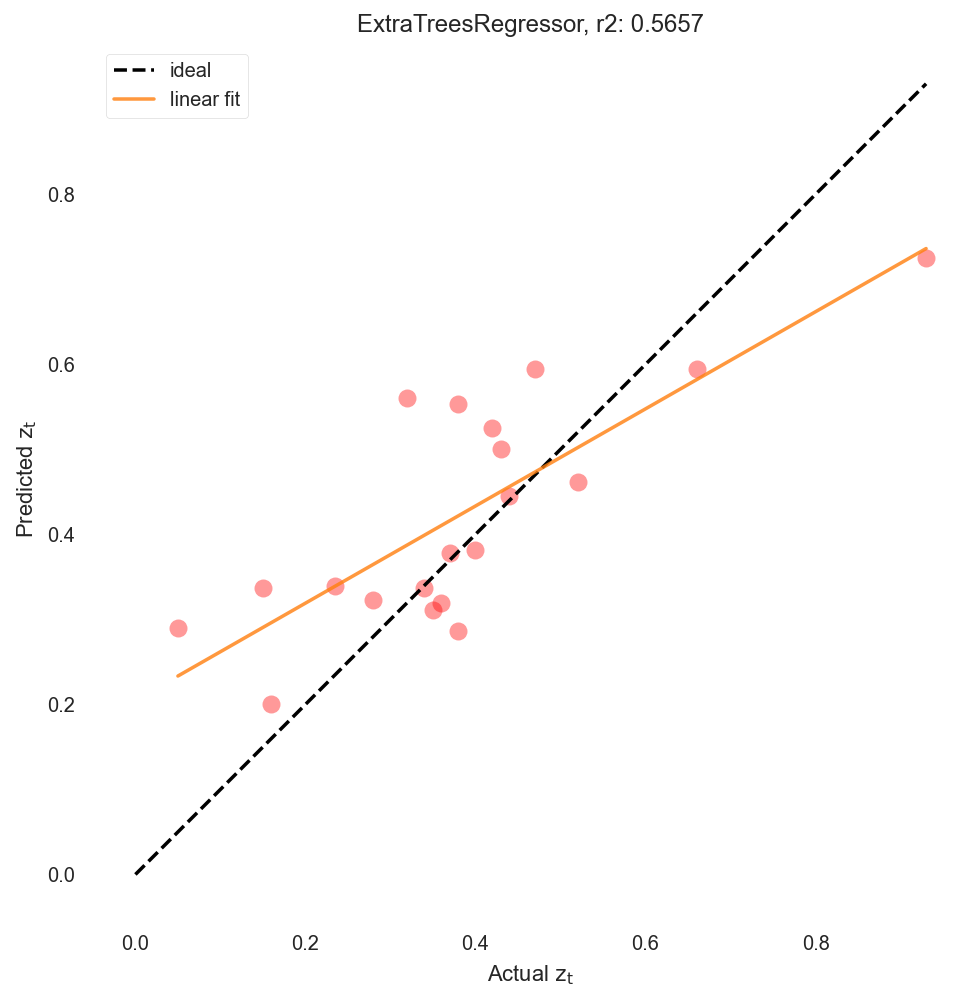

In [72]:
plot = plot_pred_act(y_act_test, y_pred_test, model, reg_line=True, label='$\mathrm{z}_\mathrm{t}$')

In [109]:
X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df_train, elem_prop='jarvis', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = generate_features(df_val, elem_prop='jarvis', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = generate_features(df_test, elem_prop='jarvis', drop_duplicates=False, extend_features=True, sum_feat=True)

Assigning Features...: 100%|██████████| 166/166 [00:00<00:00, 3619.86it/s]


	Featurizing Compositions...
	Creating Pandas Objects...


Assigning Features...: 100%|██████████| 42/42 [00:00<00:00, 3366.73it/s]


	Featurizing Compositions...
	Creating Pandas Objects...


Assigning Features...: 100%|██████████| 21/21 [00:00<00:00, 2888.64it/s]

	Featurizing Compositions...
	Creating Pandas Objects...


In [110]:
X_train_original = X_train_unscaled.copy()
X_val = X_val_unscaled.copy()
X_test = X_test_unscaled.copy()

y_train_original = y_train.copy()

In [111]:
splits = range(10)
df_splits = pd.DataFrame(columns=['split',
                                  'r2_train',
                                  'mae_train',
                                  'rmse_train',
                                  'r2_val',
                                  'mae_val',
                                  'rmse_val'])

for split in splits:
    print(f'Fitting and evaluating random split {split}')
    X_train = X_train_original.sample(frac=0.7, random_state=split)
    y_train = y_train_original[X_train.index]

    scaler = StandardScaler()
    X_train = normalize(scaler.fit_transform(X_train))
    X_val = normalize(scaler.transform(X_val_unscaled))
    X_test = normalize(scaler.transform(X_test_unscaled))
    
    model = AdaBoostRegressor()
    model.fit(X_train, y_train)
    y_act_val = y_val
    y_pred_val = model.predict(X_val)

    r2_train, mae_train, rmse_train = evaluate_model(model, X_train, y_train)
    r2_val, mae_val, rmse_val = evaluate_model(model, X_val, y_val)
    result_dict = {
        'split': split,
        'r2_train': r2_train,
        'mae_train': mae_train,
        'rmse_train': rmse_train,
        'r2_val': r2_val,
        'mae_val': mae_val,
        'rmse_val': rmse_val}
    
    df_splits = append_result_df(df_splits, result_dict)


Fitting and evaluating random split 0
Fitting and evaluating random split 1
Fitting and evaluating random split 2
Fitting and evaluating random split 3
Fitting and evaluating random split 4
Fitting and evaluating random split 5
Fitting and evaluating random split 6
Fitting and evaluating random split 7
Fitting and evaluating random split 8
Fitting and evaluating random split 9


In [112]:
df_splits['split'] = df_splits['split'].astype(int)
df_splits

,split,r2_train,mae_train,rmse_train,r2_val,mae_val,rmse_val
0,0,0.894533,0.065088,0.077235,0.624235,0.117856,0.147691
1,1,0.915450,0.060397,0.070946,0.643076,0.111481,0.143940
2,2,0.908078,0.063833,0.073412,0.549148,0.127099,0.161775
3,3,0.923961,0.055136,0.064188,0.606969,0.126796,0.151046
4,4,0.901776,0.067301,0.075818,0.565925,0.117096,0.158737
5,5,0.888640,0.064761,0.074183,0.564710,0.121379,0.158959
6,6,0.900070,0.064290,0.075299,0.645478,0.117443,0.143455
7,7,0.887846,0.064966,0.075532,0.501125,0.139554,0.170173
8,8,0.909973,0.061857,0.072387,0.626683,0.118182,0.147209
9,9,0.919954,0.060745,0.070450,0.496374,0.132336,0.170981


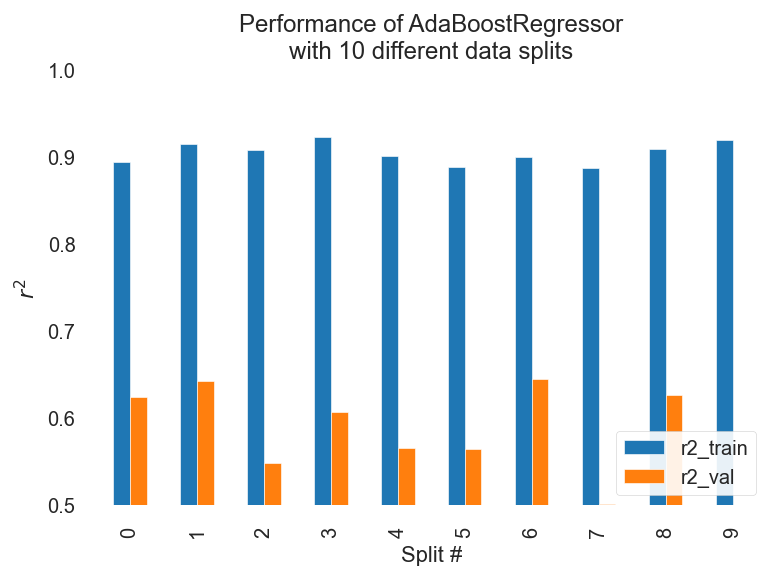

In [113]:
df_splits.plot('split', ['r2_train', 'r2_val'], kind='bar')
plt.title(f'Performance of {type(model).__name__}\nwith {len(splits)} different data splits')
plt.ylim((0.5, 1.0))
plt.ylabel('$r^2$')
plt.xlabel('Split #')
plt.legend(loc='lower right', framealpha=0.9)
plt.show()


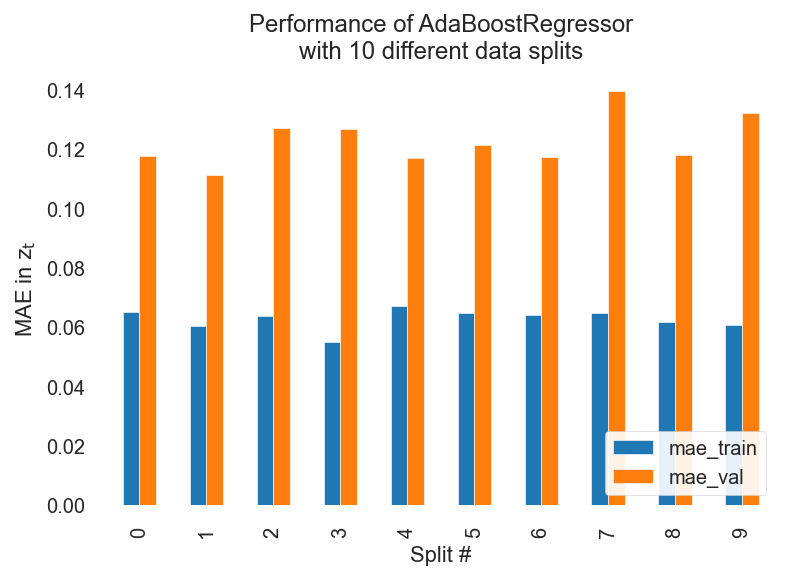

In [114]:
df_splits.plot('split', ['mae_train', 'mae_val'], kind='bar')
plt.title(f'Performance of {type(model).__name__}\nwith {len(splits)} different data splits')
plt.ylabel('MAE in $\mathrm{z}_\mathrm{t}$ ')
plt.xlabel('Split #')
plt.legend(loc='lower right', framealpha=0.9)
plt.show()

In [115]:
avg_r2_val = df_splits['r2_val'].mean()
avg_mae_val = df_splits['mae_val'].mean()

print(f'Average validation r2: {avg_r2_val:0.4f}')
print(f'Average validation MAE: {avg_mae_val:0.4f}')

Average validation r2: 0.5824
Average validation MAE: 0.1229
